In [1]:
using Pkg
Pkg.activate(".")
Pkg.instantiate()

Activating environment at `~/Research/TopographicBCI/Project.toml`


In [3]:
using
  PyPlot,
  FourierFlows,
  LinearAlgebra,
  JLD2

PyPlot.matplotlib.rc("text", usetex=true)
PyPlot.matplotlib.rc("xtick", labelsize=8)
PyPlot.matplotlib.rc("ytick", labelsize=8)
PyPlot.matplotlib.rc("axes", labelsize=10)    # fontsize of the x and y labels
PyPlot.matplotlib.rc("font", family="sans-serif")
PyPlot.rc("text.latex", preamble="\\usepackage[T1]{fontenc} \\renewcommand*\\familydefault{\\sfdefault}  \\usepackage{sansmath}  \\sansmath")

using Statistics: mean
using Printf: @sprintf
using FFTW
using FFTW: rfft, irfft

import GeophysicalFlows.MultilayerQG
import GeophysicalFlows.MultilayerQG: fwdtransform!, invtransform!, streamfunctionfrompv!, energies, fluxes

In [4]:
nx, ny, L = 256, 256, 2.0
gr = TwoDGrid(nx, L, ny, L)

nlayers = 2      # these choice of parameters give the
f0, g = 1, 1     # desired PV-streamfunction relations
H = [0.2, 0.8]   # q1 = Δψ1 + 25*(ψ2-ψ1), and
ρ = [4.0, 5.0]   # q2 = Δψ2 + 25/4*(ψ1-ψ2).

U = zeros(ny, nlayers)
U[:, 1] = @. sech(gr.y/0.2)^2

x, y = gridpoints(gr)
k0, l0 = gr.k[2], gr.l[2] # fundamental wavenumbers
eta = @. 3cos(10k0*x)*cos(10l0*y)
dt, stepper = 0.005, "FilteredRK4"

prob = MultilayerQG.Problem(nlayers=nlayers, nx=nx, U=U, Lx=L, f0=f0, g=g, H=H, ρ=ρ, eta=eta, linear=true, dt=dt, stepper=stepper)
sol, cl, pr, vs, gr = prob.sol, prob.clock, prob.params, prob.vars, prob.grid

qi = zeros(gr.nx, gr.ny, nlayers)
qi[:, :, 1] = 1e-5*randn(gr.nx, gr.ny)
qi[:, :, 2] = 1e-5*randn(gr.nx, gr.ny)

qh = rfft(qi, [1, 2])

q = zeros(size(qi))

invtransform!(q, qh, pr)


psih = zeros(size(qh))*im
psi = zeros(size(q))

streamfunctionfrompv!(psih, qh, pr.invS, gr)
invtransform!(psi, psih, pr)

MultilayerQG.set_q!(prob, q)

ke = MultilayerQG.energies(prob)

fac = 1e-5
@. sol *= prob.timestepper.filter
sol .= fac*sol/maximum(abs.(sol))

E = Diagnostic(energies, prob; nsteps=1)
diags = [E];


In [5]:
function plot_output(fig, axs)

    for j in 1:nlayers
        maxq = maximum(abs.(vs.q[:, :, j]))
        levels = range(-maxq[1], maxq[1], length=50)

        sca(axs[j])
        cla()
        contourf(x, y, vs.q[:, :, j], levels=levels)
        xlim(-L/2, L/2)
        ylim(-L/2, L/2)
        axis("equal")
        axis("square")
        xticks([-1, 0, 1])
        yticks([-1, 0, 1])
        title("PV, layer "*string(j))

        maxψ = maximum(abs.(vs.psi[:, :, j]))
        levels = range(-maxψ[1], maxψ[1], length=10)

        sca(axs[j+nlayers])
        cla()
        contourf(x, y, vs.psi[:, :, j], levels=levels)
        contour(x, y, vs.psi[:, :, j], levels=levels, colors="k")
        xlim(-L/2, L/2)
        ylim(-L/2, L/2)
        axis("equal")
        axis("square")
        xticks([-1, 0, 1])
        yticks([-1, 0, 1])
        title("streamfunction, layer "*string(j))
    end

    sca(axs[5])
    cla()
    plot(1:length(growth), growth, "*")
    title(L"growth rate $= "*"$(@sprintf("%.3f", growth[end]))"*L"$")

    sca(axs[6])
    cla()
    plot(1:length(growth), mom1thick, "o")
    title(L"lateralfluxes$_1$ / verticalfluxes $="*"$(@sprintf("%.3f", ke1ke2[end]))"*L"$")
    xlabel("\\# iterations")

    # plot(ke1ke2, "s")
    # title(L"ke$_1$ /  ke$_2 = "*"$(@sprintf("%.3f", ke1ke2[end]))")

end

plot_output (generic function with 1 method)

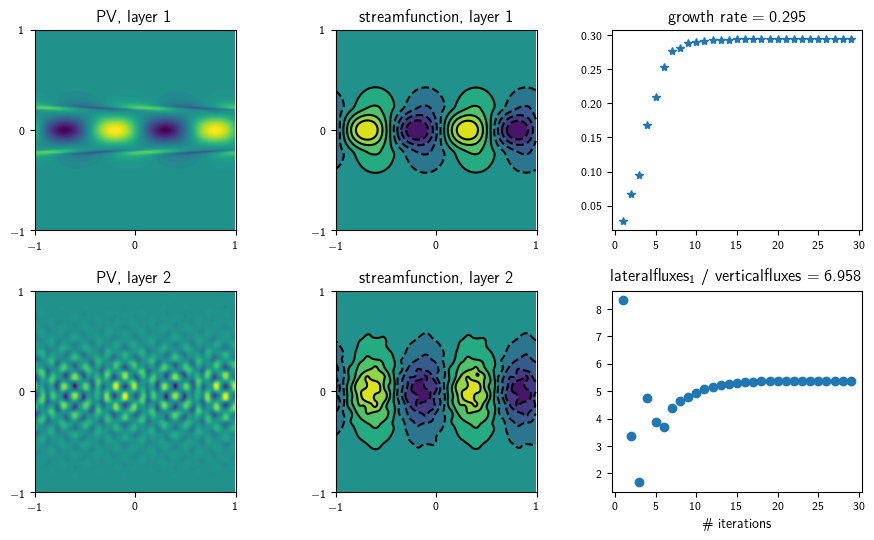

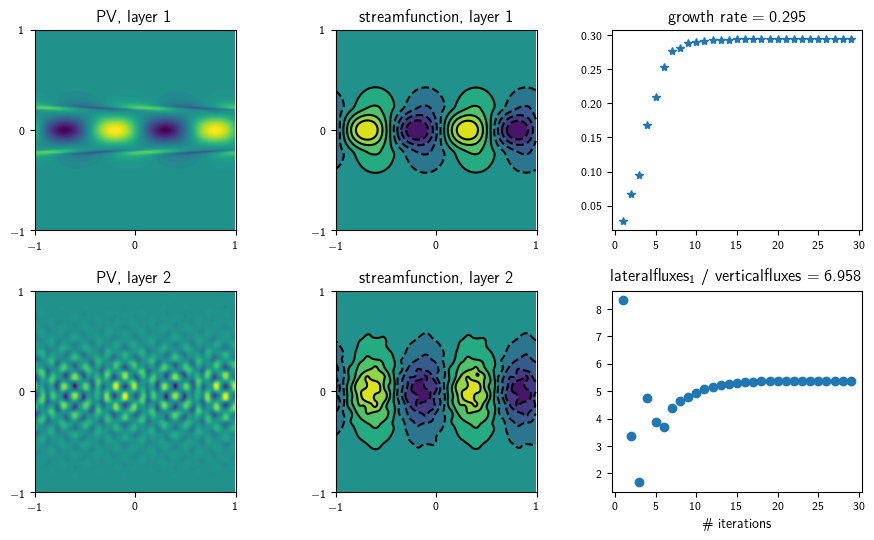

7.438153655537627e-6


In [6]:
nsubsteps = 500

errortol = 1e-5

error = 1
i = 1

fig, axs = subplots(ncols=3, nrows=2, figsize=(11, 6), num=1)
subplots_adjust(hspace=0.3)


growth=[0]
mom1thick=[0]
ke1ke2=[0]
MultilayerQG.updatevars!(prob)
plot_output(fig, axs)
growth = []
mom1thick = []
ke1ke2 = []

while error > errortol
    MultilayerQG.updatevars!(prob)
    
    (ke0, pe0) = MultilayerQG.energies(prob)
    stepforward!(prob, diags, nsubsteps)
    (ke, pe) = MultilayerQG.energies(prob)
    (lateralfluxes, verticalfluxes) = fluxes(prob)
    sol .= fac*sol/maximum(abs.(sol))
    
    # compute growth based on kinetic energy growth (average between layers)
    append!(growth, mean([log.(ke[1]/ke0[1])/(2*nsubsteps*dt), log.(ke[2]/ke0[2])/(2*nsubsteps*dt)]))
    append!(mom1thick, lateralfluxes[1]/verticalfluxes[1])
    append!(ke1ke2, ke[1]/ke[2])
  
    plot_output(fig, axs)
    sleep(0.001)
    IJulia.clear_output(true)
    display(fig)

    if i>1
        global error = abs(growth[i]-growth[i-1])/abs(growth[i])
    end
    println(error)
    global i += 1

end

In [7]:
growthrate = growth[end]
mom1thick = mom1thick[end]
@save "eigen-h3-n256.jld2" sol growthrate mom1thick